## FB Prophet Demand Forecasting  & Vizualizations of Store Sales Data

In [64]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [65]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [139]:
df = pd.read_csv('store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [140]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

id: A unique identifier for each record.

date: The date of the sales record. This shows when the sales data was recorded.

store_nbr: This represents the store number or identifier. It tells you which Favorita store the sales data is coming from. 

family: This column categorizes the type of products sold. Examples include "AUTOMOTIVE", "BABY CARE", "BEAUTY", "BEVERAGES", "BOOKS", etc. It helps in analyzing which product categories are performing well in terms of sales.

sales: This shows the sales amount for the given product category, in the specified store, on the particular date. 

onpromotion: This column indicates whether the product category was on promotion on the given date. It's represented as a numerical value, '0' means no promotion. 

In [142]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [143]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [144]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


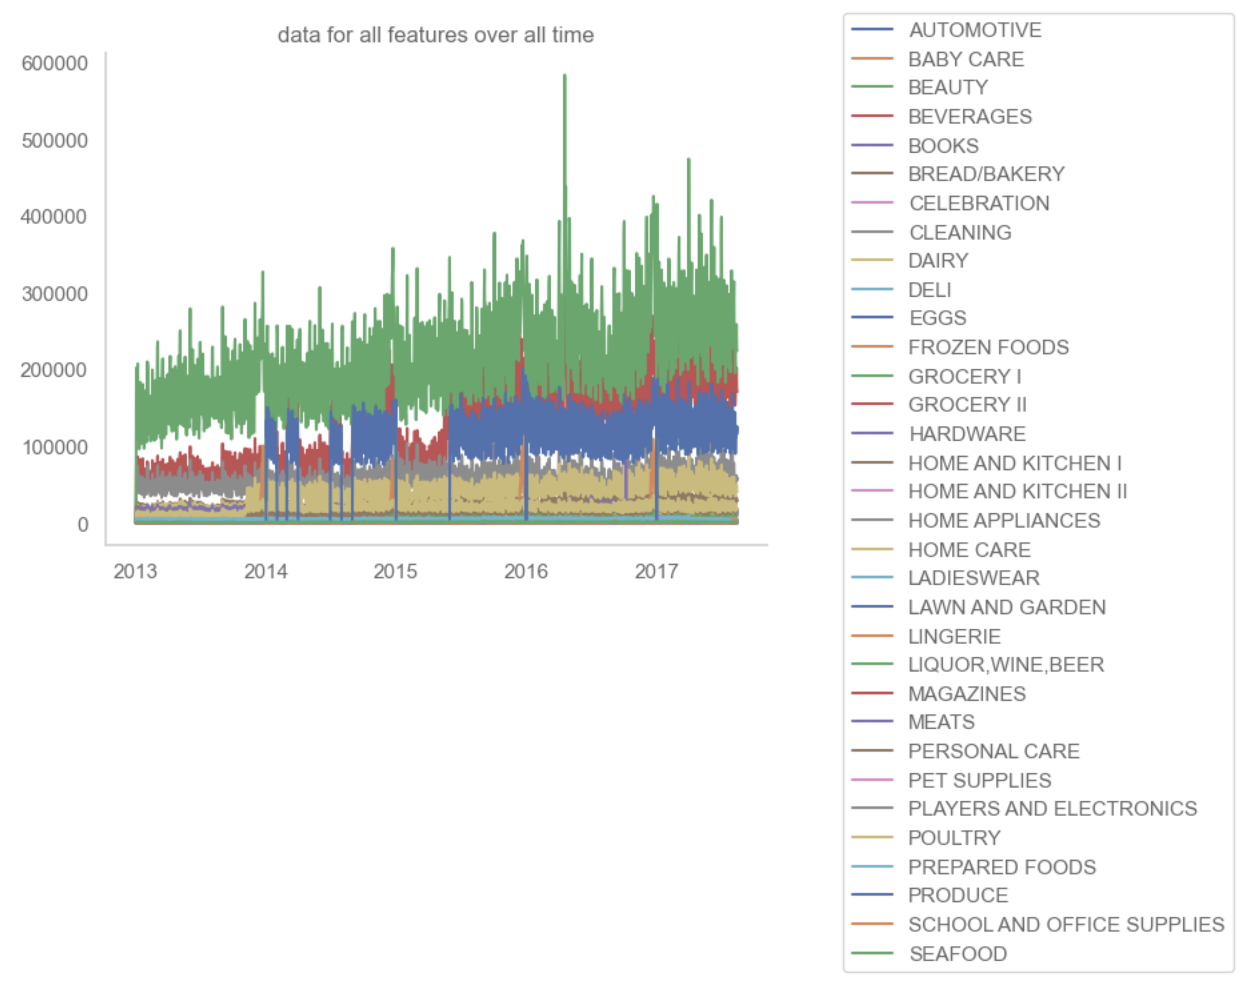

In [145]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


### Visualizing the sales of each family

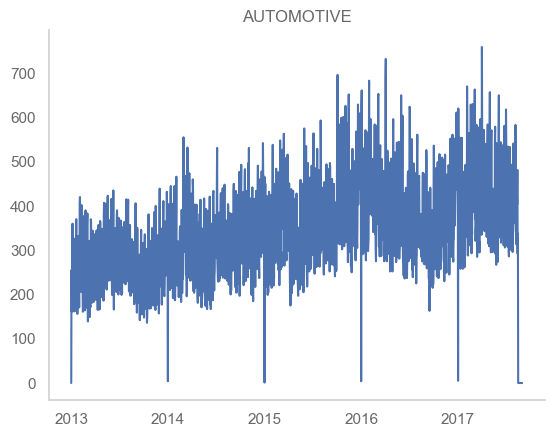

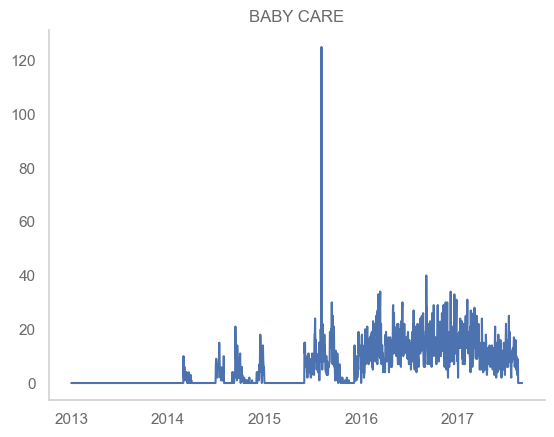

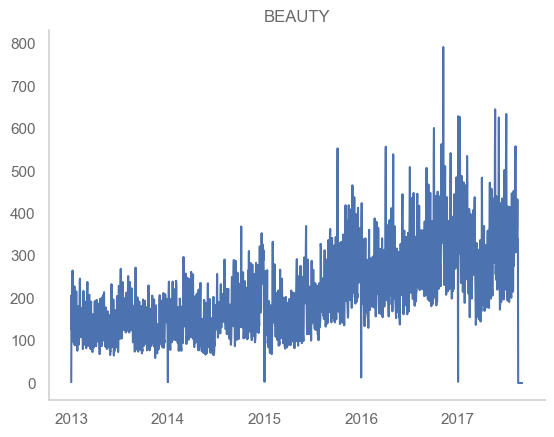

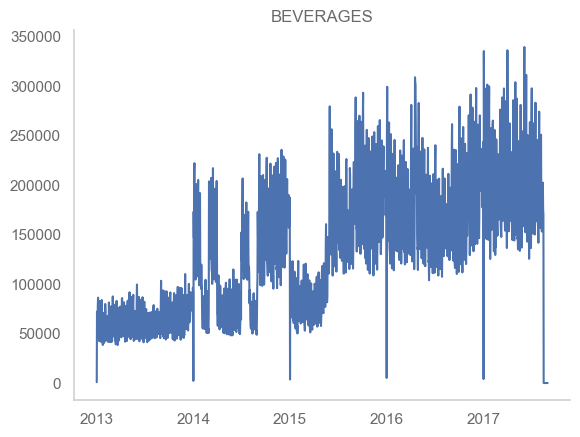

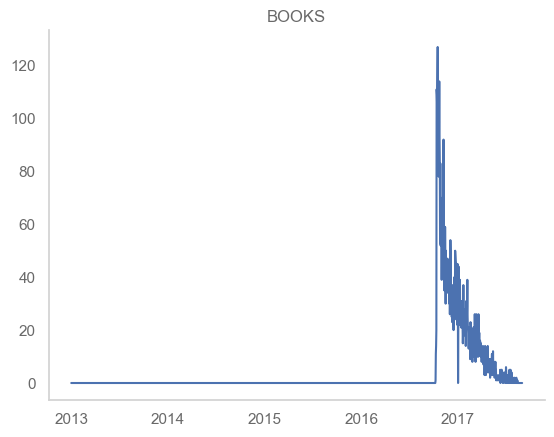

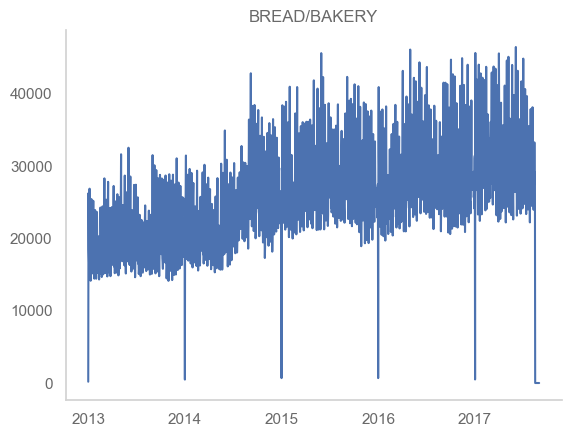

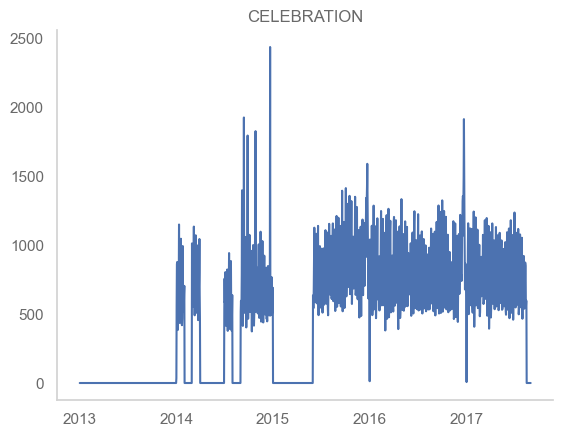

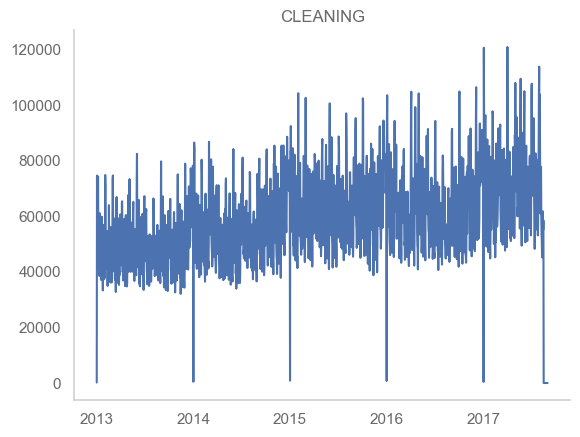

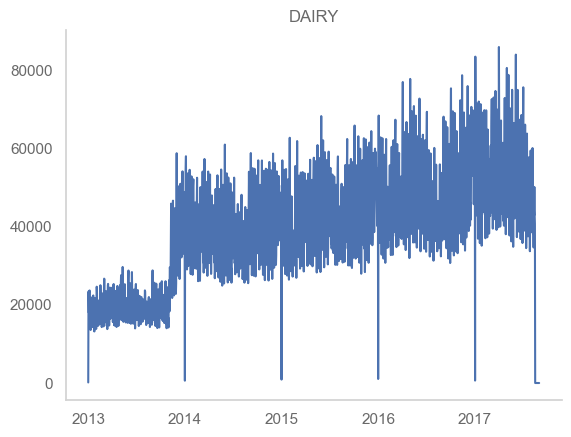

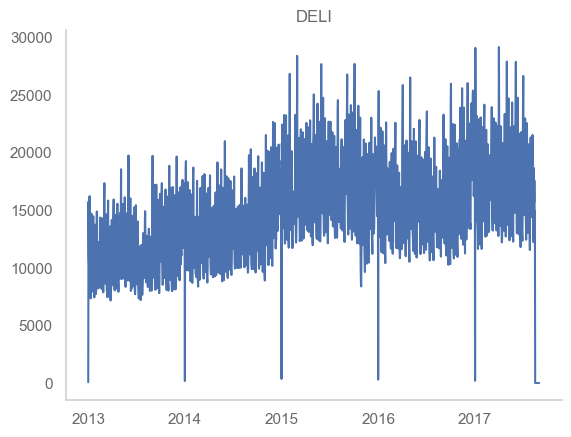

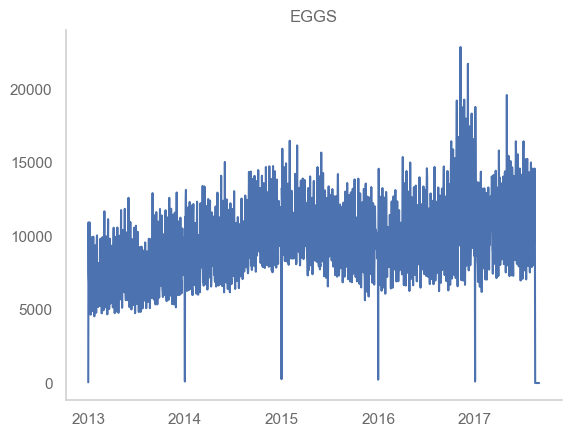

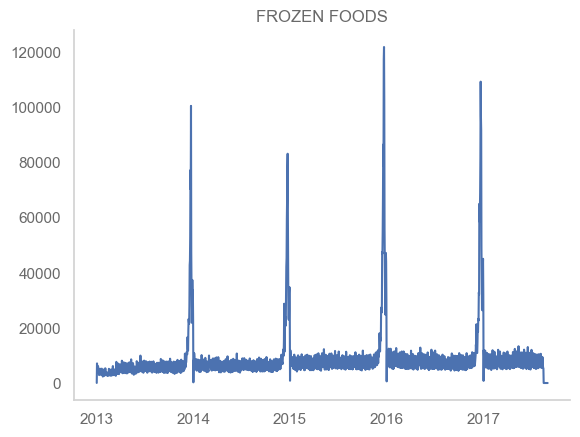

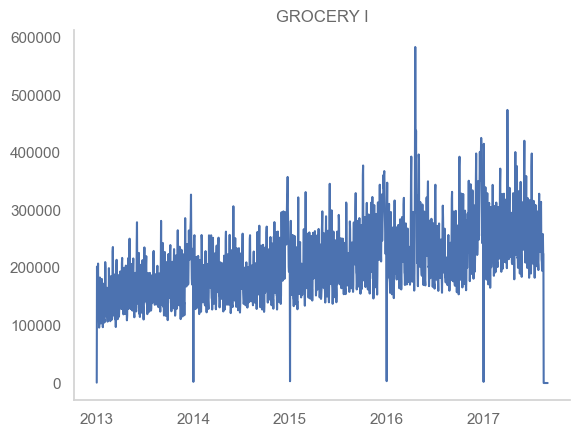

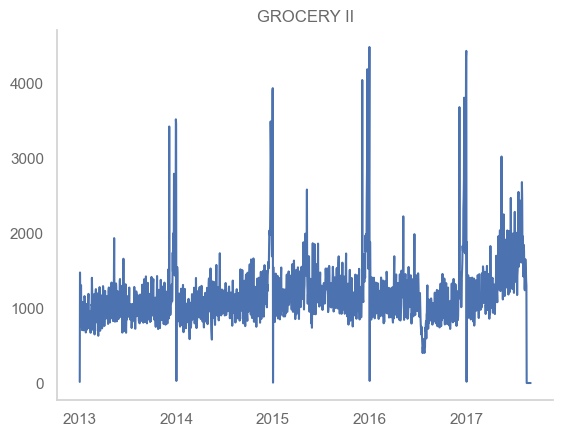

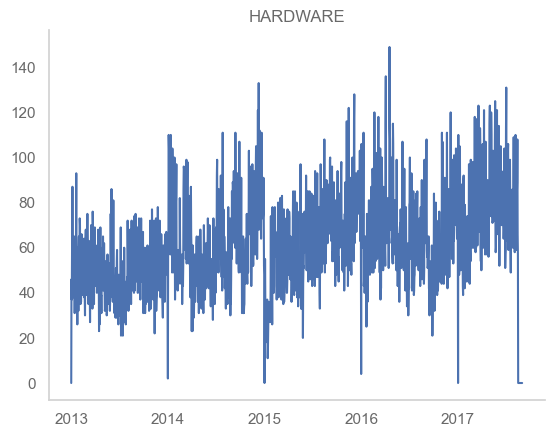

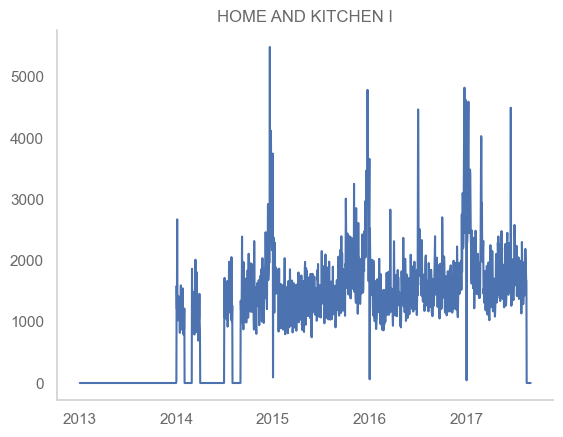

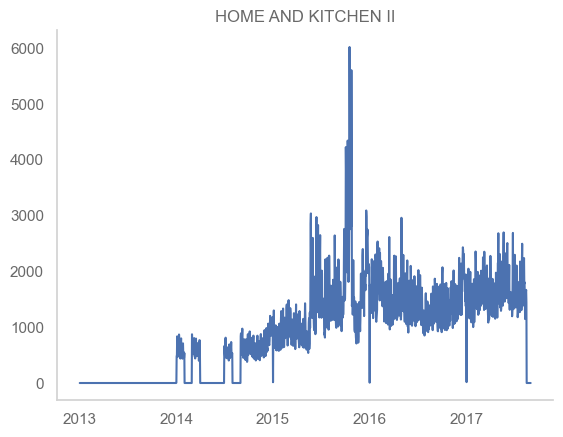

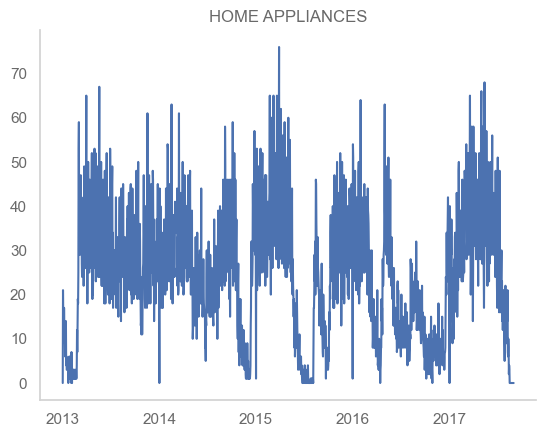

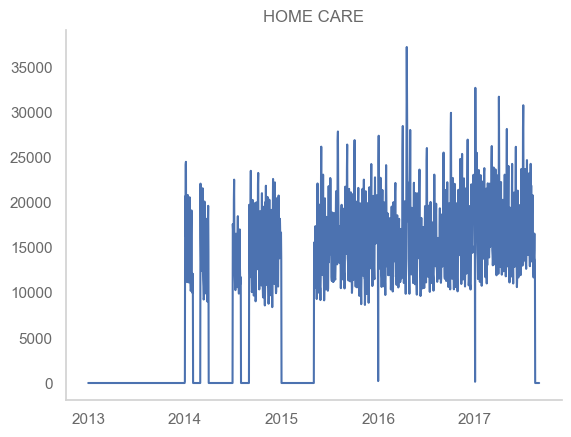

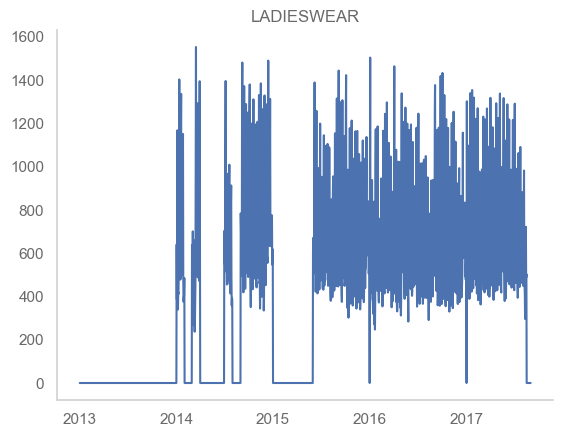

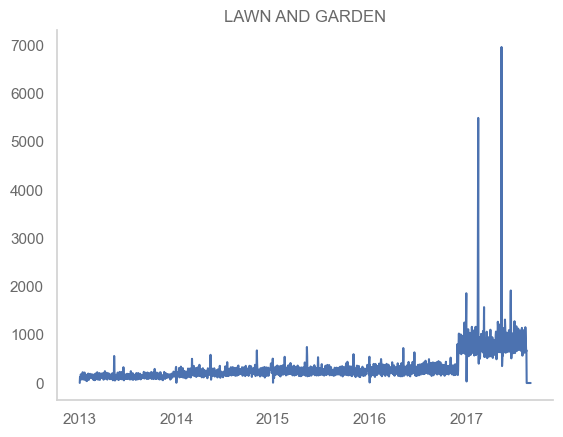

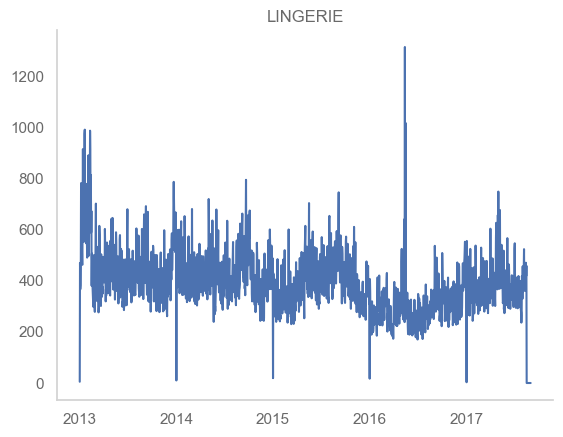

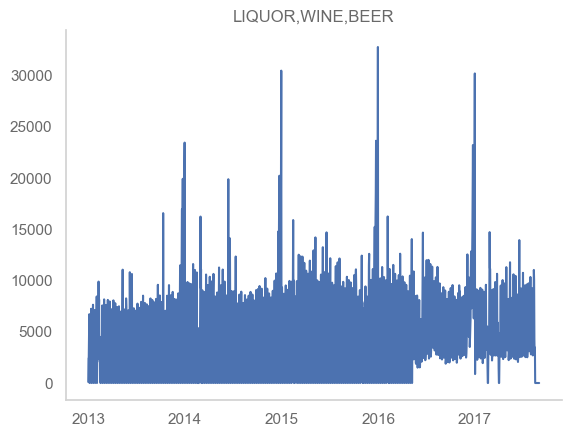

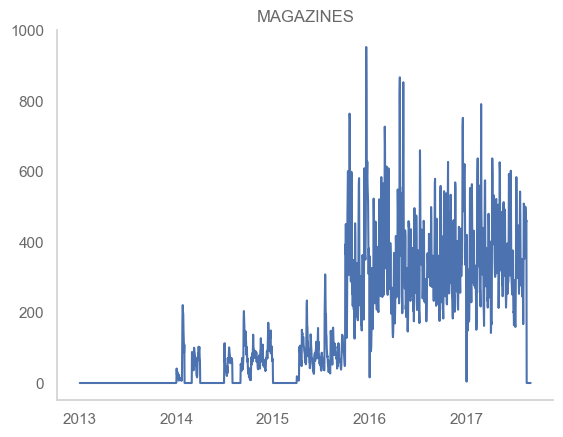

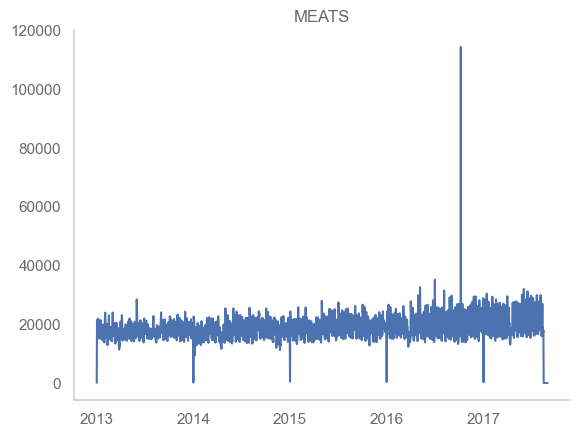

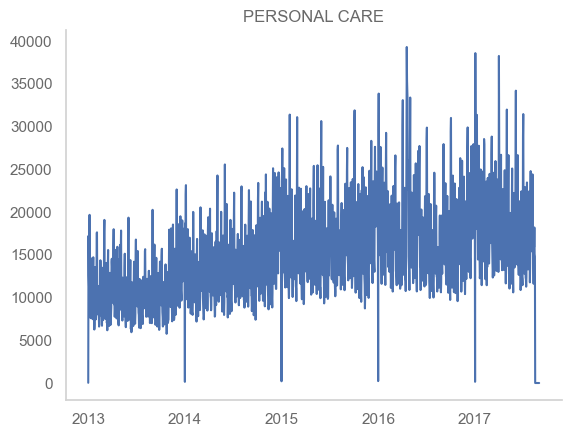

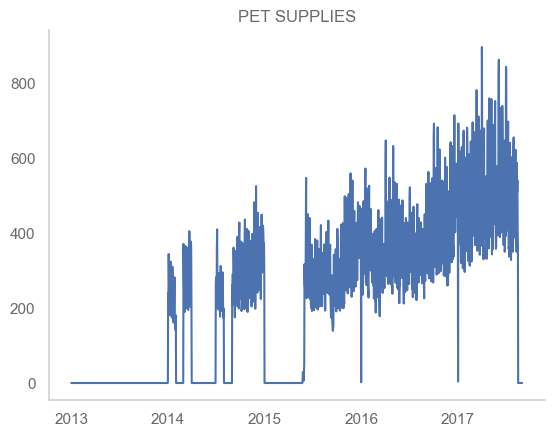

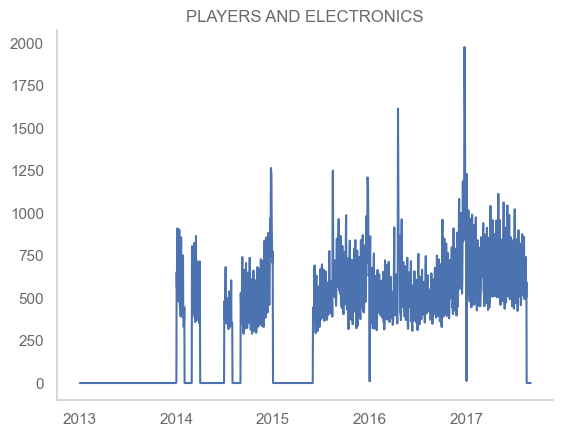

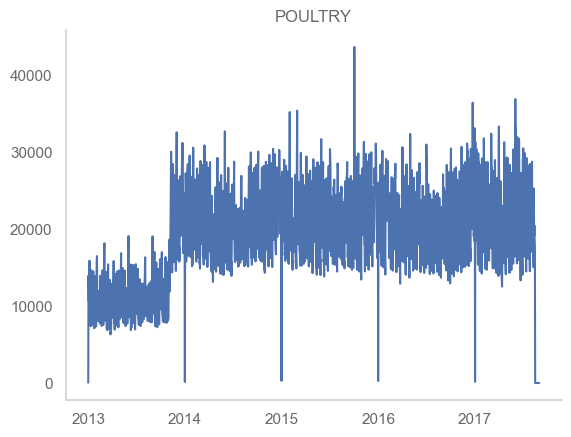

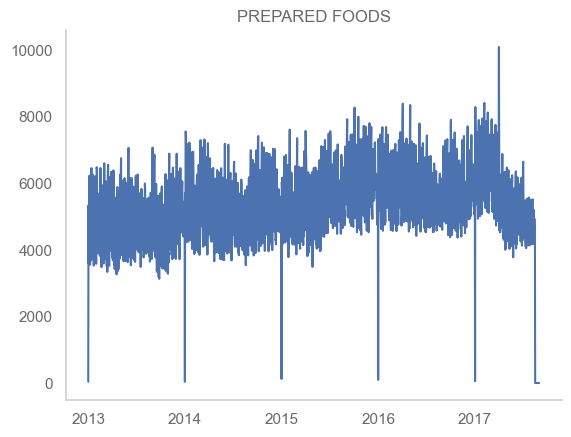

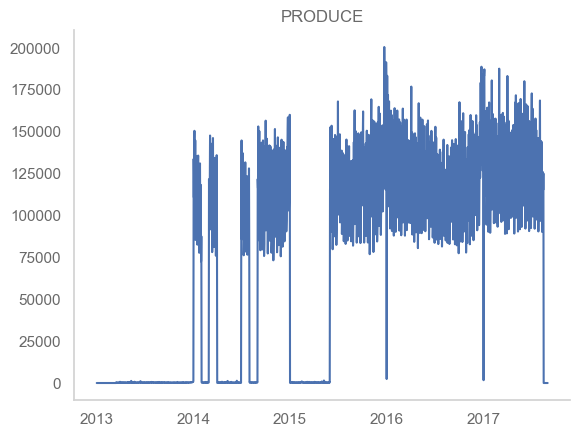

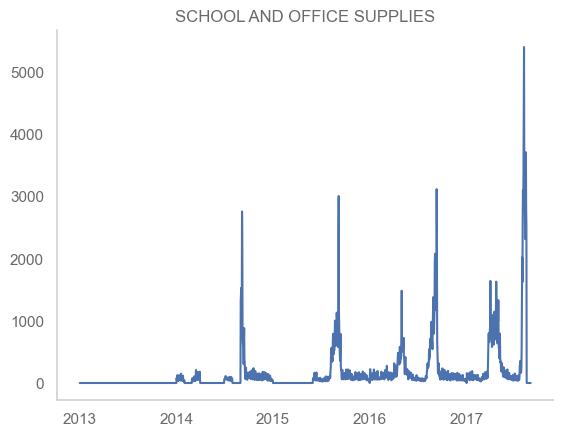

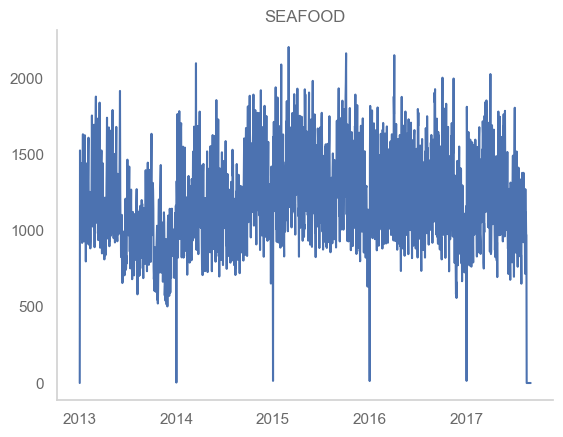

In [74]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

We will consider the sales data after August 15, 2015, as there is a more prominent trend observed in the categories.

In [147]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [148]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


#### Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

### Category Grouping

In [149]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [150]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

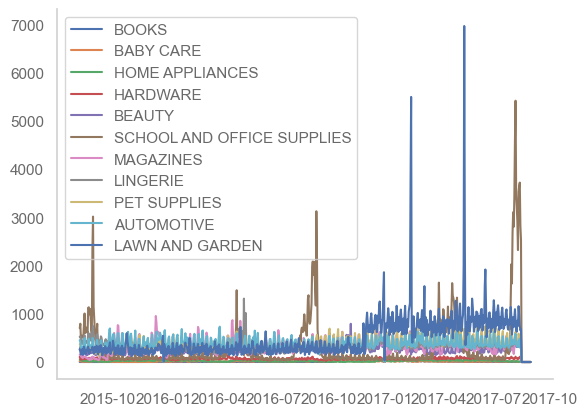

In [151]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

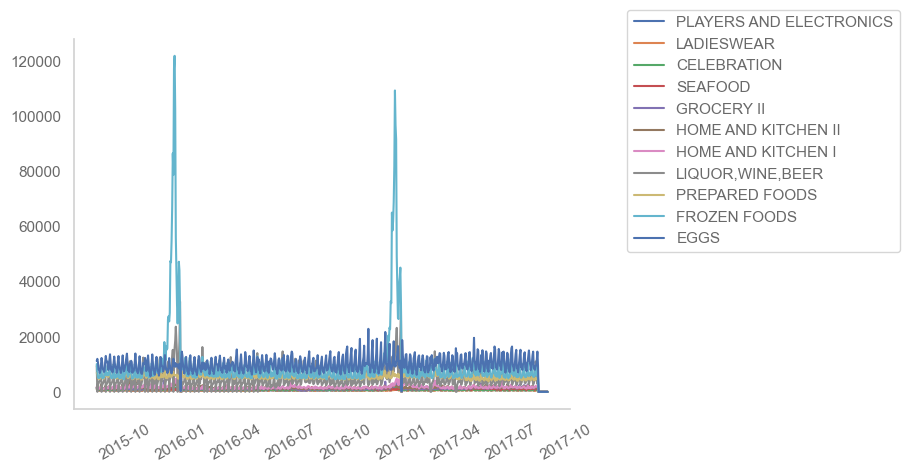

In [152]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

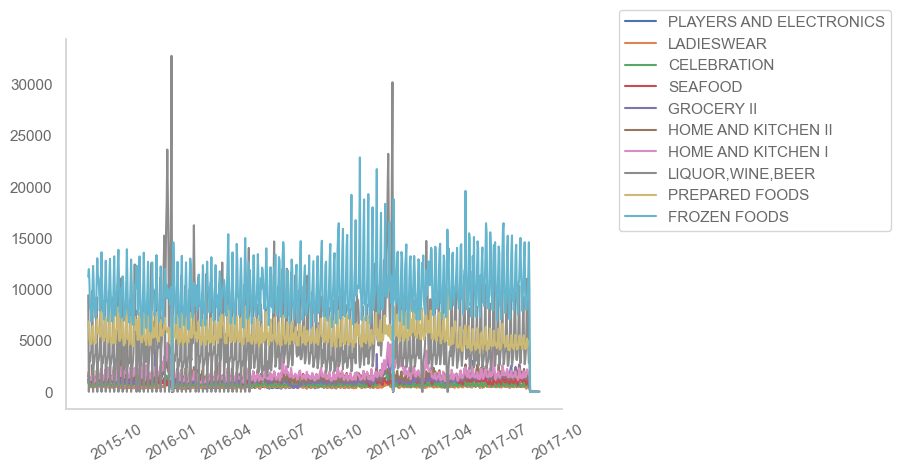

In [153]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

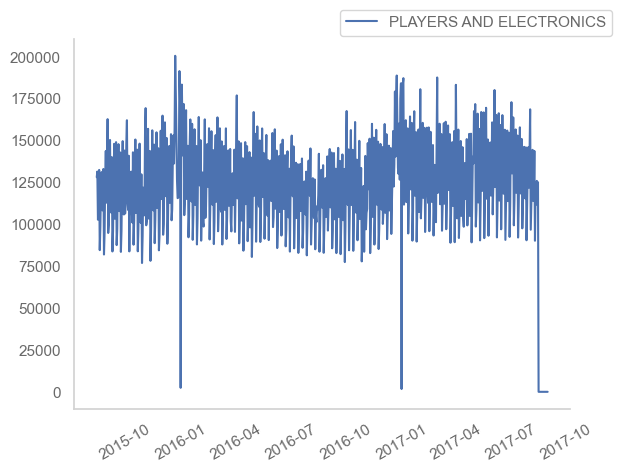

In [154]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

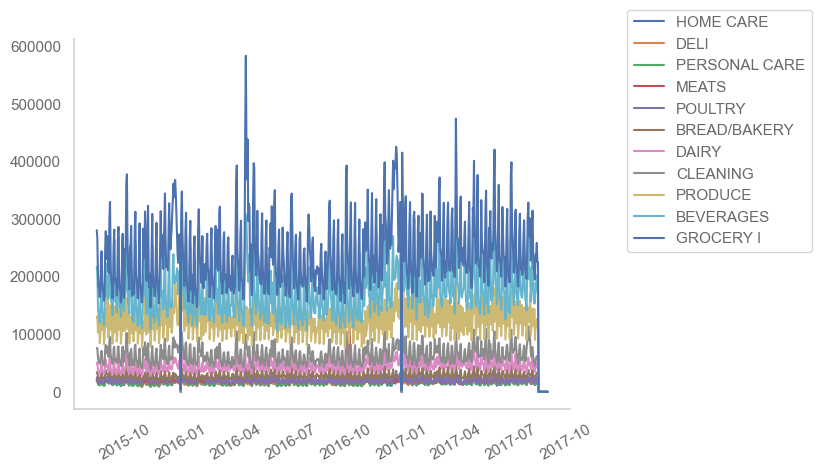

In [155]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE."

In [156]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [157]:
df = total_sales_df[[feature]].reset_index()
df.head()

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58


In [158]:
# Initialize an empty DataFrame named 'holiday' to store holiday data
holiday = pd.DataFrame([])

# Retrieve Ecuador's public holidays using the 'holidays' library. This creates a dictionary
# where keys are dates and values are the names of the holidays.
ecuador_holidays = holidays.EC()  # Retrieves holidays for Ecuador

# The same as above, but using a string to specify the country. This is more explicit and can be clearer.
ecuador_holidays = holidays.country_holidays('EC')  # Also retrieves holidays for Ecuador

# Loop through the holidays for the years 2015, 2016, 2017, and 2018.
# For each holiday, create a DataFrame with the holiday date, a custom holiday name 'EC-Holidays',
# and a window around the holiday date (-2 to 1 days).
# Then concatenate this DataFrame with the 'holiday' DataFrame created earlier.
for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat(
        [holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], 
        ignore_index=True
    ) 

# Convert the 'ds' column of the 'holiday' DataFrame to a datetime format. This is important
# for consistency when merging or comparing with other date columns in time series data.
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Display the first few rows of the 'holiday' DataFrame for inspection.
holiday.head()


,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


https://pypi.org/project/holidays/

In [159]:
# Define a specific date using Python's 'date' object from the datetime module.
# Here, it's set to July 1, 2017. This date represents the start of the forecast period.
forecast_start_dt = date(2017,7,1) # The dataset ends on August 15, 2017.

# Convert the 'forecast_start_dt' date object to a string in the format 'YYYY-MM-DD'.
# This format is commonly used for representing dates in string format, especially in data analysis and databases.
forecast_start_date = forecast_start_dt.strftime("%Y-%m-%d") 

# Print the formatted date string to the console. This is useful for verification or debugging purposes.
print(forecast_start_date)


2017-07-01


m = Prophet(growth='linear',
            changepoint_range = changepoint_range,
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            seasonality_mode='multiplicative',
            holidays=holiday)

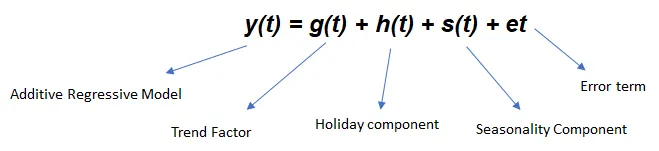

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [162]:
# Copying the original DataFrame to preserve the original data
df_copy = df.copy()

# Renaming columns to fit Prophet model requirements: 'ds' for the date column and 'y' for the feature to predict
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})

# Converting the target variable 'y' to numeric type for the model to process
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

# Converting the 'ds' column to datetime format for time series analysis
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# Creating a training dataset by filtering rows where the date is before the forecast start date
train_set = df_copy[(df_copy['ds'] < forecast_start_date)]

# Initializing the Prophet model
m = Prophet()

# Fitting the Prophet model on the training dataset
m.fit(train_set)

# Creating a future dataframe for the model to predict on, 
# with a specified number of days to predict ('prediction_days')
future = m.make_future_dataframe(periods=prediction_days)

# Generating predictions using the Prophet model
fcst_prophet_train = m.predict(future)

# Applying a filter to include only the forecasted data from the forecast start date
filter = fcst_prophet_train['ds'] >= forecast_start_date 

# Creating a new DataFrame with the forecasted dates and predictions ('yhat')
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]


10:31:48 - cmdstanpy - INFO - Chain [1] start processing
10:31:49 - cmdstanpy - INFO - Chain [1] done processing


In [164]:
predicted_df.head(10)

,ds,yhat
684,2017-07-01,144575.74
685,2017-07-02,155299.42
686,2017-07-03,122346.96
687,2017-07-04,127605.78
688,2017-07-05,160216.34
689,2017-07-06,102630.81
690,2017-07-07,115979.45
691,2017-07-08,144826.81
692,2017-07-09,155550.48
693,2017-07-10,122598.02


<b> variable considerations for prophet model: </b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [165]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [166]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144575.74,155487.63
1,2017-07-02,155299.42,172890.14
2,2017-07-03,122346.96,130389.20
3,2017-07-04,127605.78,131534.55
4,2017-07-05,160216.34,163804.33
5,2017-07-06,102630.81,99395.60
6,2017-07-07,115979.45,114346.57
7,2017-07-08,144826.81,139294.77
8,2017-07-09,155550.48,156633.92
9,2017-07-10,122598.02,118856.99


In [167]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

6.244464641516742

### Cross Validation with Prophet
Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [127]:
# Initialize a Prophet model and assign it to variable 'm'
m = Prophet()

# Fit the Prophet model on the training dataset 'train_set'
m.fit(train_set)

# Perform cross-validation on the Prophet model
# - 'initial': The size of the initial training period (365 days in this case)
# - 'period': The spacing between cutoff dates for cross-validation (30 days here)
# - 'horizon': The forecast horizon (30 days in this instance)
# This process will help in understanding the model's predictive performance
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon='30 days')


09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:16 - cmdstanpy - INFO - Chain [1] done processing
09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:16 - cmdstanpy - INFO - Chain [1] done processing
09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:16 - cmdstanpy - INFO - Chain [1] done processing
09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:16 - cmdstanpy - INFO - Chain [1] done processing
09:52:16 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1] done processing
09:52:17 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1] done processing
09:52:17 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1] done processing
09:52:17 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1] done processing
09:52:17 - cmdstanpy - INFO - Chain [1] start processing
09:52:17 - cmdstanpy - INFO - Chain [1]

horizon: This indicates the number of days into the future for which the predictions were made. For instance, '3 days' means the prediction was made for 3 days into the future.

mse (Mean Squared Error): This is a measure of the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. A lower MSE indicates a more accurate model. 

rmse (Root Mean Squared Error): This is the square root of the mean squared error. It's a commonly used measure of the differences between values predicted by a model and the values actually observed. Like MSE, a lower RMSE is better. 

mae (Mean Absolute Error): This metric measures the average magnitude of the errors in a set of predictions, without considering their direction. It's the average over the test sample of the absolute differences between prediction and actual observation. A lower MAE indicates a better fit. 

mape (Mean Absolute Percentage Error): This measures the size of the error in percentage terms. It is calculated as the average of the absolute percentage errors of the predictions. A lower MAPE value indicates a better fit. 

mdape (Median Absolute Percentage Error): Similar to MAPE but uses the median instead of the mean, which can provide a better view of the typical error if the data contains outliers. 

smape (Symmetric Mean Absolute Percentage Error): This is an accuracy measure based on percentage errors. Unlike MAPE, SMAPE has both the forecast and the actuals symmetrically in the denominator. A lower SMAPE value indicates better accuracy. 

coverage: This metric represents the proportion of actual values that fall within the prediction intervals. A coverage of '0.80' for the 3-day horizon means that 80% of the actual values fell within the predicted interv

In [168]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,377632985.42,19432.78,13388.32,0.09,0.08,0.10,0.80
1,4 days,255353027.69,15979.77,11133.34,0.08,0.07,0.08,0.80
2,5 days,129465166.83,11378.28,8585.12,0.07,0.05,0.07,0.83
3,6 days,120672938.78,10985.12,8776.52,0.07,0.05,0.07,0.83
4,7 days,86166215.22,9282.58,8017.49,0.06,0.05,0.06,0.90
5,8 days,80066730.49,8948.00,7766.44,0.06,0.06,0.06,0.94
6,9 days,64433156.82,8027.03,6771.40,0.06,0.05,0.05,1.00
7,10 days,48183276.97,6941.42,5509.52,0.05,0.03,0.05,1.00
8,11 days,79571769.26,8920.30,6951.41,0.06,0.04,0.06,0.97
9,12 days,101361116.83,10067.83,7136.67,0.05,0.03,0.05,0.93


In [106]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,413743179.86,20340.68,13091.15,0.09,0.07,0.10,0.77
1,4 days,270700553.38,16452.98,11135.25,0.08,0.06,0.08,0.80
2,5 days,142152184.03,11922.76,8933.43,0.07,0.06,0.07,0.87
3,6 days,126756036.99,11258.60,9259.41,0.07,0.07,0.07,0.87
4,7 days,96637781.92,9830.45,8450.28,0.07,0.07,0.07,0.93


In [129]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,254530488.31,15954.01,11995.66,0.10,0.08,0.10,0.80
24,27 days,304955739.67,17462.98,13239.90,0.11,0.09,0.11,0.77
25,28 days,501795501.64,22400.79,15723.82,0.13,0.09,0.13,0.73
26,29 days,548597623.74,23422.16,16632.82,0.12,0.09,0.13,0.66
27,30 days,1247070121.68,35313.88,21527.12,3.01,0.12,0.19,0.63


df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [170]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,102707.15,86831.39,118377.79,176327.97,2016-12-02,41.75,False
116,2016-12-30,103135.63,87394.71,117011.66,175022.19,2016-12-02,41.07,False
109,2016-12-22,92065.13,75806.61,106950.80,140444.94,2016-12-02,34.45,False
119,2017-01-02,122044.64,102460.39,140427.97,184113.03,2017-01-01,33.71,False
120,2017-01-03,126375.37,106816.41,145191.97,183306.23,2017-01-01,31.06,False
111,2016-12-24,132094.20,115803.84,147796.62,188809.16,2016-12-02,30.04,False
117,2016-12-31,132522.69,116692.41,148547.74,184154.67,2016-12-02,28.04,False
115,2016-12-29,92493.61,77446.34,108668.45,126652.84,2016-12-02,26.97,False
238,2017-05-01,122372.70,102976.40,141260.18,167558.58,2017-04-01,26.97,False
263,2017-05-26,104100.03,85911.31,121625.35,136728.88,2017-05-01,23.86,False


In [171]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2016-09-04,135367.65,118856.17,151445.54,144954.39,2016-09-03,6.61,False
1,2016-09-05,101990.63,85665.37,119380.32,110104.68,2016-09-03,7.37,False
2,2016-09-06,106055.96,87681.33,122068.14,115898.16,2016-09-03,8.49,False
3,2016-09-07,138318.67,120966.06,155238.65,142809.15,2016-09-03,3.14,False
4,2016-09-08,82508.52,66264.79,98827.07,85680.68,2016-09-03,3.70,False
5,2016-09-09,92024.61,76935.81,107204.31,96152.02,2016-09-03,4.29,False
6,2016-09-10,122018.66,106119.45,138963.64,128750.47,2016-09-03,5.23,False
7,2016-09-11,134711.21,119803.72,151274.47,142536.23,2016-09-03,5.49,False
8,2016-09-12,101334.20,85049.70,117373.78,102988.54,2016-09-03,1.61,False
9,2016-09-13,105399.53,88995.72,120917.43,104210.54,2016-09-03,-1.14,True


Optimizing for "PRODUCE" feature. What that means is... <b> lets hypertune this model! </b>

In [172]:
# Define a grid of hyperparameters to tune. 'changepoint_prior_scale' and 'seasonality_prior_scale'
# have different values to be tested.
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all possible combinations of parameters from the grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Initialize a list to store the RMSE for each parameter combination

# Loop through each combination of parameters
for params in all_params:
    # Create and fit a Prophet model with the current set of parameters
    m = Prophet(**params).fit(train_set)

    # Perform cross-validation with the specified initial training period, period between cutoffs,
    # and forecast horizon. 'parallel="processes"' enables parallel processing for faster computation.
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon='30 days', parallel='processes')

    # Calculate performance metrics for the cross-validated predictions
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Append the RMSE of the current parameter set to the 'rmses' list
    rmses.append(df_p['rmse'].values[0])

# Combine the parameter sets with their corresponding RMSE values into a DataFrame
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# 'tuning_results' now contains each set of parameters and their associated RMSE,
# allowing for identification of the best-performing parameter set.


10:36:03 - cmdstanpy - INFO - Chain [1] start processing
10:36:03 - cmdstanpy - INFO - Chain [1] done processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] done processing
10:36:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:04 - cmdstanpy - INFO - Chain [1] start processing
10:36:04 - cmdstanpy - INFO - Chain [1] done processing
10:36:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:0

10:36:10 - cmdstanpy - INFO - Chain [1] done processing
10:36:10 - cmdstanpy - INFO - Chain [1] done processing
10:36:10 - cmdstanpy - INFO - Chain [1] done processing
10:36:10 - cmdstanpy - INFO - Chain [1] done processing
10:36:11 - cmdstanpy - INFO - Chain [1] done processing
10:36:11 - cmdstanpy - INFO - Chain [1] done processing
10:36:11 - cmdstanpy - INFO - Chain [1] start processing
10:36:11 - cmdstanpy - INFO - Chain [1] done processing
10:36:13 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] start processing
10:36:13 - cmdstanpy - INFO - Chain [1] done processing
10:36:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:36:13 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
10:36:13 - cmdstanpy - INFO - Chain [1] done processing

10:36:22 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1

10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] done processing
10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1]

In [173]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.78
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18507.77
3                      0.00                    10.00 18681.85
4                      0.01                     0.01 18218.70
5                      0.01                     0.10 17780.35
6                      0.01                     1.00 17757.39
7                      0.01                    10.00 17708.34
8                      0.10                     0.01 18086.66
9                      0.10                     0.10 17707.07
10                     0.10                     1.00 17703.48
11                     0.10                    10.00 17704.72
12                     0.50                     0.01 18100.54
13                     0.50                     0.10 17751.35
14                     0.50                     1.00 17755.61
15      

In [174]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
10,0.10,1.00,17703.48
11,0.10,10.00,17704.72
9,0.10,0.10,17707.07
7,0.01,10.00,17708.34
15,0.50,10.00,17731.98
13,0.50,0.10,17751.35
14,0.50,1.00,17755.61
6,0.01,1.00,17757.39
5,0.01,0.10,17780.35
8,0.10,0.01,18086.66


In [175]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale       1.00
rmse                      17703.48
Name: 0, dtype: float64

In [176]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 1.0,
 'rmse': 17703.480104978196}

In [177]:
# Extracting the best parameters from the tuning results.
# The tuning results are sorted by RMSE in ascending order. The best (lowest RMSE) parameters are at the top (index 0).
# 'reset_index(drop=True)' resets the index of the sorted DataFrame and 'drop=True' removes the old index.
# 'drop('rmse', axis='columns')' removes the 'rmse' column, leaving only the parameter columns.
# 'iloc[0]' selects the first row, which contains the best parameter combination.
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

# Creating a new Prophet model instance with the best hyperparameters.
# 'changepoint_prior_scale' and 'seasonality_prior_scale' are set to the values found in the previous step.
# This model is now configured with the optimal parameters as determined by the previous hyperparameter tuning.
m = Prophet(changepoint_prior_scale=params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale=params_dictionary['seasonality_prior_scale'])


In [178]:
# Fit the optimized Prophet model on the training dataset 'train_set'
m.fit(train_set)

# Create a DataFrame that extends into the future by a specified number of days ('prediction_days')
future = m.make_future_dataframe(periods=prediction_days)

# Use the model to make predictions on the future DataFrame
fcst_prophet_train = m.predict(future)

# Apply a filter to include only the forecasted data from the forecast start date onwards
filter = fcst_prophet_train['ds'] >= forecast_start_date 

# Create a new DataFrame 'predicted_df' with dates and their corresponding forecasted values ('yhat')
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

# Copy the original DataFrame and rename its columns to 'ds' and 'ytrue' for date and actual values
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']

# Merge the predicted DataFrame with the actual values DataFrame on the date column 'ds'
# This allows us to compare the forecasted values with the actual values
predicted_df = predicted_df.merge(df_copy)

# Calculate the Mean Absolute Percentage Error (MAPE) between the actual values ('ytrue') 
# and the predicted values ('yhat')
# MAPE is a measure of prediction accuracy and a lower value indicates a better fit
mape(predicted_df['ytrue'], predicted_df['yhat'])


10:47:17 - cmdstanpy - INFO - Chain [1] start processing
10:47:17 - cmdstanpy - INFO - Chain [1] done processing


4.878875316556208